In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [8]:
# Load and preprocess images from a single train folder
def load_images_from_folder(folder_path, target_size=(224, 224)):
    images = []
    labels = []
    class_names = os.listdir(folder_path)
    for label in class_names:
        class_folder = os.path.join(folder_path, label)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                img = tf.keras.utils.load_img(img_path, target_size=target_size)
                img_array = tf.keras.utils.img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels), class_names
# Define folder path to training images
folder_path = "../../data4/train" 

# Load the data
X, y, class_names = load_images_from_folder(folder_path)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train and test sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


In [9]:
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
# Improved Hybrid Model
def build_improved_hybrid_model(num_classes):
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for base_model in [resnet_base, vgg_base, inception_base]:
        base_model.trainable = False

    input_tensor = Input(shape=(224, 224, 3))
    resnet_output = GlobalAveragePooling2D()(resnet_base(input_tensor))
    vgg_output = GlobalAveragePooling2D()(vgg_base(input_tensor))
    inception_output = GlobalAveragePooling2D()(inception_base(input_tensor))

    # Add normalization before concatenation
    resnet_output = BatchNormalization()(resnet_output)
    vgg_output = BatchNormalization()(vgg_output)
    inception_output = BatchNormalization()(inception_output)

    merged = concatenate([resnet_output, vgg_output, inception_output])
    x = Dense(512, activation='relu')(merged)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)  # Additional trainable layer
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

num_classes = len(class_names)
model = build_improved_hybrid_model(num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy', 'AUC'])


In [10]:
# Train the hybrid model
history = model.fit(X_train_final, y_train_final, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)


Epoch 1/10


2024-12-30 00:58:25.467402: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at segment_reduction_ops_impl.h:494 : INVALID_ARGUMENT: data.shape = [32] does not start with segment_ids.shape = [160]
2024-12-30 00:58:25.467519: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: data.shape = [32] does not start with segment_ids.shape = [160]
	 [[{{function_node __inference_one_step_on_data_40105}}{{node UnsortedSegmentSum_1}}]]
2024-12-30 00:58:25.471628: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at segment_reduction_ops_impl.h:494 : INVALID_ARGUMENT: data.shape = [32] does not start with segment_ids.shape = [160]


InvalidArgumentError: Graph execution error:

Detected at node UnsortedSegmentSum_1 defined at (most recent call last):
  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/folders/g6/k0zd0rqs50lgsg8slwmw40rr0000gn/T/ipykernel_5771/3721007031.py", line 2, in <module>

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 77, in train_step

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/trainer.py", line 444, in compute_metrics

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/compile_utils.py", line 330, in update_state

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/compile_utils.py", line 17, in update_state

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/metrics/confusion_metrics.py", line 1376, in update_state

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/metrics/metrics_utils.py", line 481, in update_confusion_matrix_variables

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/metrics/metrics_utils.py", line 277, in _update_confusion_matrix_variables_optimized

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/ops/math.py", line 59, in segment_sum

  File "/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/backend/tensorflow/math.py", line 17, in segment_sum

data.shape = [32] does not start with segment_ids.shape = [160]
	 [[{{node UnsortedSegmentSum_1}}]] [Op:__inference_one_step_on_iterator_41658]

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Hybrid Model Test Loss: {test_loss:.2f}")
print(f"Hybrid Model Test Accuracy: {test_accuracy:.2f}")


In [ ]:

# Plot training history
def plot_training_history(history):
    metrics = ['accuracy', 'loss']
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_history(history)

# Plot ROC Curve
def plot_roc_curve(y_true, y_pred, num_classes):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

predictions = model.predict(X_test)
plot_roc_curve(y_test, predictions, num_classes)

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, predictions, class_names)

# Classification Report
def print_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, np.argmax(y_pred, axis=1), target_names=class_names)
    print("Classification Report:")
    print(report)

print_classification_report(y_test, predictions, class_names)


In [5]:

# Fine-Tuning the Improved Hybrid Model
def fine_tune_model(model, train_generator, validation_generator, base_models, fine_tune_layers, learning_rate=1e-5, epochs=10):
    for base_model, layers_to_unfreeze in zip(base_models, fine_tune_layers):
        for layer in base_model.layers[-layers_to_unfreeze:]:
            layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

    fine_tune_history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler]
    )
    return fine_tune_history

resnet_base = model.get_layer("resnet50")
vgg_base = model.get_layer("vgg16")
inception_base = model.get_layer("inception_v3")
fine_tune_layers = [20, 10, 15]  # Increased unfreezing

fine_tune_history = fine_tune_model(
    model,
    train_generator,
    validation_generator,
    base_models=[resnet_base, vgg_base, inception_base],
    fine_tune_layers=fine_tune_layers,
    learning_rate=1e-5,
    epochs=20
)
    

Epoch 1/20


/Users/liraj/.pyenv/versions/3.9.4/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 2108s 11s/step - AUC: 0.6324 - accuracy: 0.3691 - loss: 1.5574 - val_AUC: 0.7811 - val_accuracy: 0.5544 - val_loss: 1.1071 - learning_rate: 1.0000e-05
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1782s 9s/step - AUC: 0.8103 - accuracy: 0.5685 - loss: 1.0661 - val_AUC: 0.8644 - val_accuracy: 0.6364 - val_loss: 0.8871 - learning_rate: 1.0000e-05
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1785s 9s/step - AUC: 0.8454 - accuracy: 0.6085 - loss: 0.9681 - val_AUC: 0.8870 - val_accuracy: 0.6651 - val_loss: 0.8256 - learning_rate: 1.0000e-05
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1780s 9s/step - AUC: 0.8740 - accuracy: 0.6419 - loss: 0.8723 - val_AUC: 0.8954 - val_accuracy: 0.6752 - val_loss: 0.8111 - learning_rate: 1.0000e-05
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1794s 10s/step - AUC: 0.8839 - accuracy: 0.6632 - loss: 0.8322 - val_AUC: 0.8998 - val_accuracy: 0.6818 - val_loss: 0.7842 - learning_rate: 1.0000e-05
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1781s 9s/step - AUC

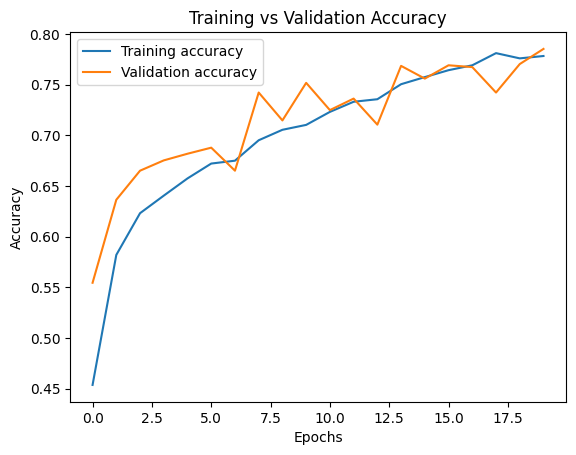

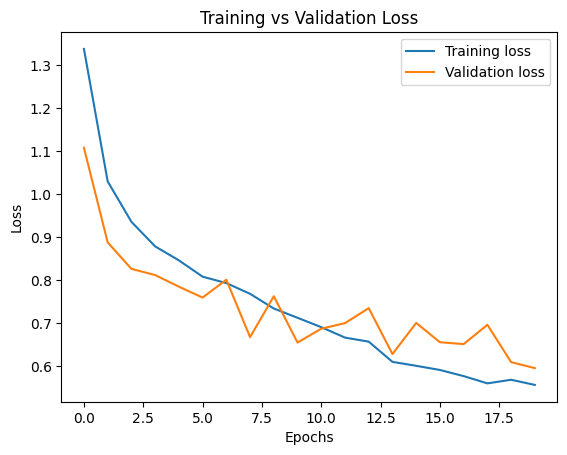

In [6]:
import matplotlib.pyplot as plt

def plot_training_results(history, metrics=["accuracy", "loss"]):
    """
    Plots training and validation metrics for each metric in the list.

    Parameters:
    - history: The history object returned by model.fit().
    - metrics: A list of metric names to plot (e.g., ["accuracy", "loss"]).
    """
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

# Plot accuracy and loss for the initial training
plot_training_results(fine_tune_history, metrics=["accuracy", "loss"])


In [7]:
model.save("../../models/improved_hybrid_model.keras")

In [8]:

# Evaluate the Improved Model
results = model.evaluate(validation_generator)
print(f"Validation Loss: {results[0]:.2f}")
print(f"Validation Accuracy: {results[1]:.2f}")

# Classification report and confusion matrix
val_preds = np.argmax(model.predict(validation_generator), axis=1)
true_labels = validation_generator.classes
print(classification_report(true_labels, val_preds, target_names=validation_generator.class_indices.keys()))
print(confusion_matrix(true_labels, val_preds))
    

53/53 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - AUC: 0.9451 - accuracy: 0.7844 - loss: 0.5854
Validation Loss: 0.59
Validation Accuracy: 0.79
53/53 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.31      0.30      0.30       450
      2. Ekzama       0.26      0.29      0.28       450
        3. Akne       0.19      0.20      0.20       322
      4. Malign       0.26      0.24      0.25       450

       accuracy                           0.26      1672
      macro avg       0.26      0.26      0.26      1672
   weighted avg       0.26      0.26      0.26      1672

[[134 130  76 110]
 [115 131 102 102]
 [ 70  98  65  89]
 [112 138  94 106]]


In [14]:
import joblib

# Improved Feature Extraction for KNN and RF
# feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

def extract_features(model, generator):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(feature_extractor, train_generator)
val_features, val_labels = extract_features(feature_extractor, validation_generator)

pca = PCA(n_components=128)  # Dimensionality reduction
train_features_pca = pca.fit_transform(train_features)
val_features_pca = pca.transform(val_features)

pca_model_path = "../../models/pca_model.pkl"
joblib.dump(pca, pca_model_path)

print(f"PCA model saved at {pca_model_path}")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features_pca, train_labels)
knn_accuracy = accuracy_score(val_labels, knn.predict(val_features_pca))
print(f"KNN Validation Accuracy: {knn_accuracy:.2f}")

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(train_features_pca, train_labels)
rf_accuracy = accuracy_score(val_labels, rf.predict(val_features_pca))
print(f"Random Forest Validation Accuracy: {rf_accuracy:.2f}")
    

188/188 ━━━━━━━━━━━━━━━━━━━━ 935s 5s/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 273s 5s/step
PCA model saved at ../../models/pca_model.pkl
KNN Validation Accuracy: 0.24
Random Forest Validation Accuracy: 0.26


In [16]:

# Save the KNN model
joblib.dump(knn, '../../models/improved_knn_model.pkl')

# Save the Random Forest model
joblib.dump(rf, '../../models/improved_random_forest_model.pkl')

print("Models saved successfully!")

Models saved successfully!


In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the ROC curve
def plot_roc_curve(true_labels, predicted_probabilities, class_names):
    """
    Plots the ROC curve for a multi-class classification problem.

    Parameters:
    - true_labels: True labels (one-hot encoded or integer-encoded).
    - predicted_probabilities: Predicted probabilities for each class.
    - class_names: List of class names or indices.
    """
    # Binarize the true labels if they are not one-hot encoded
    if len(true_labels.shape) == 1:
        true_labels = label_binarize(true_labels, classes=range(len(class_names)))

    n_classes = len(class_names)
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), predicted_probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot the ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot(fpr["micro"], tpr["micro"], linestyle='--', label=f"Micro-average (AUC = {roc_auc['micro']:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Get true labels and predicted probabilities from validation data
def get_validation_results(model, validation_generator):
    validation_steps = validation_generator.samples // validation_generator.batch_size
    true_labels = []
    predicted_probabilities = []

    for i in range(validation_steps):
        x_batch, y_batch = next(validation_generator)
        true_labels.extend(np.argmax(y_batch, axis=1))  # Integer-encoded labels
        predicted_probabilities.extend(model.predict(x_batch))  # Predicted probabilities

    true_labels = np.array(true_labels)
    predicted_probabilities = np.array(predicted_probabilities)
    return true_labels, predicted_probabilities

# Example Usage
class_names = list(validation_generator.class_indices.keys())
true_labels, predicted_probabilities = get_validation_results(model, validation_generator)

# Plot the ROC curve
plot_roc_curve(true_labels, predicted_probabilities, class_names)


NameError: name 'model' is not defined